# ConvexNet v0版本：不输入特征，单纯拟合T和Y之间的函数（要求满足先验凸性假设），用于检验模型拟合能力（或者说解空间大小）

# 该版本实验结果表明，ConvexNet无论是拟合一般函数还是分段函数，在只使用1～2层核函数层的情况下，拟合优度$R^2$都能达到0.99以上，足以说明ConvexNet的拟合能力很强，解空间比较大。

In [1]:
import torch
from torch import nn
import torch.utils.data as data
import matplotlib.pyplot as plt
from torchmetrics.functional import r2_score

# 模型注意事项：
# 1. 实例化网络时需要输入T（treatment样本）和Y（output样本），原因是网络需要寻找合适的初始化参数，有利于训练时网络的收敛。
# 2. 参数kernel_num可以输入整数，如100，也可以输入元组/列表，如(50, 100, 200)。前者表示核函数层只有1层，每层有100个节点，后者表示核函数层有3层，第一层50个节点，第二层100个节点，第三层200个节点。（核函数层的具体定义和构造方法请查阅说明文档）

In [12]:
# 定义核函数网络

class ConvexNet(nn.Module):


    def __init__(self, X, Y, kernel_num):
        super(ConvexNet, self).__init__()

        self.linear_parameter = dict()
        if isinstance(kernel_num, int):
            kernel_num = tuple([kernel_num])
        self.kernel_num = kernel_num
        
        stream = X
        for i, k in enumerate(kernel_num):
            w, b = self.linear_init(stream)
            W = (w.repeat(k).reshape(k, -1).T*(torch.rand(k) + 1))**0.5
            B = b.repeat(k) + torch.randn(k)
            self.linear_parameter[f'W{i}'] = nn.Parameter(W)
            self.register_parameter(f'W{i}', self.linear_parameter[f'W{i}'])
            self.linear_parameter[f'B{i}'] = nn.Parameter(B)
            self.register_parameter(f'B{i}', self.linear_parameter[f'B{i}'])
            stream = self.kernel(stream@W**2 + B)
        w, b = self.linear_init(stream)
        W = (w.repeat(Y.shape[1]).reshape(Y.shape[1], -1).T*Y.std(axis=0))**0.5
        B = (b.repeat(Y.shape[1]))*Y.std(axis=0) + Y.mean(axis=0)
        self.linear_parameter[f'W{i + 1}'] = nn.Parameter(W)
        self.register_parameter(f'W{i + 1}', self.linear_parameter[f'W{i + 1}'])
        self.linear_parameter[f'B{i + 1}'] = nn.Parameter(B)
        self.register_parameter(f'B{i + 1}', self.linear_parameter[f'B{i + 1}'])


    def forward(self, X):
        for i in range(len(self.kernel_num)):
            X = self.kernel(X@self.linear_parameter[f'W{i}']**2 + self.linear_parameter[f'B{i}'])
        Y = X@self.linear_parameter[f'W{i + 1}']**2 + self.linear_parameter[f'B{i + 1}']
        return Y


    def linear_init(self, input, mean=0, std=1):
        w = std/input.std(axis=0)
        scale = std/(input@w).std()
        w = w*scale
        b = mean - (input@w).mean()
        return w, b


    def kernel(self, input):
        
        output = torch.zeros_like(input)
        ix1 = int(input.shape[1]/4)
        ix2 = 2*ix1
        ix3 = int((input.shape[1] - ix2)/2) + ix2

        output[:, :ix1] = input[:, :ix1] - torch.log(torch.exp(input[:, :ix1]) + 1)
        
        output[:, ix1:ix2][input[:, ix1:ix2] >= 0] = torch.log(input[:, ix1:ix2][input[:, ix1:ix2] >= 0] + 1)
        output[:, ix1:ix2][input[:, ix1:ix2] < 0] = torch.log(1 - input[:, ix1:ix2][input[:, ix1:ix2] < 0]) + 2*input[:, ix1:ix2][input[:, ix1:ix2] < 0]
       
        a1 = torch.linspace(0, 1, ix3 - ix2 + 1)[1:].repeat((input.shape[0], 1))
        pos1 = (input[:, ix2:ix3] >= 0)
        neg1 = (input[:, ix2:ix3] < 0)
        output[:, ix2:ix3][pos1] = (input[:, ix2:ix3][pos1] + 1)**a1[pos1] - 1
        output[:, ix2:ix3][neg1] = (1 - input[:, ix2:ix3][neg1])**a1[neg1] + 2*a1[neg1]*input[:, ix2:ix3][neg1] - 1
       
        a2 = torch.linspace(0, 1, input.shape[1] - ix3 + 1)[1:].repeat((input.shape[0], 1))
        pos2 = (input[:, ix3:] >= 0)
        neg2 = (input[:, ix3:] < 0)
        output[:, ix3:][pos2] = -1/((input[:, ix3:][pos2] + 1)**a2[pos2]) + 1
        output[:, ix3:][neg2] = -1/((1 - input[:, ix3:][neg2])**a2[neg2]) + 2*a2[neg2]*input[:, ix3:][neg2] + 1
      
        return output

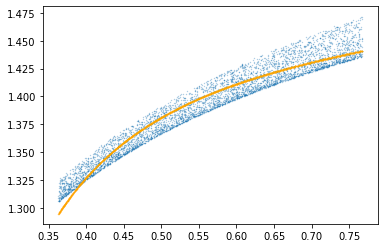

In [14]:
# 随机生成数据并初始化网络

sample_size = 5000
X = torch.rand(1)*(torch.rand(sample_size, 1) + torch.rand(1))
Y = torch.log(torch.log(torch.log(torch.log(X + 1) + 1)) + 0.2*X*torch.rand(sample_size, 1)**2 + 5)
CN = ConvexNet(X, Y, kernel_num=100)
Y_pred = CN(X)
plt.scatter(X, Y, s=0.1, alpha=0.5)
plt.scatter(X.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)

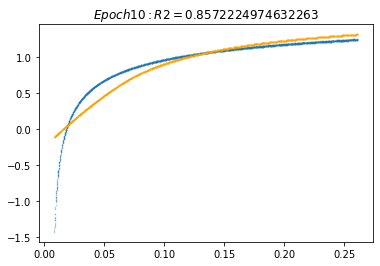

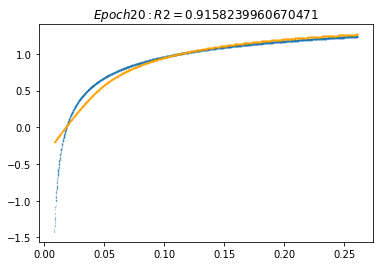

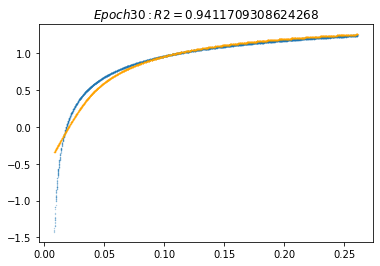

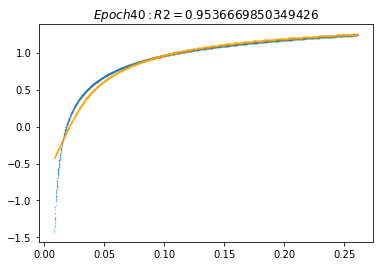

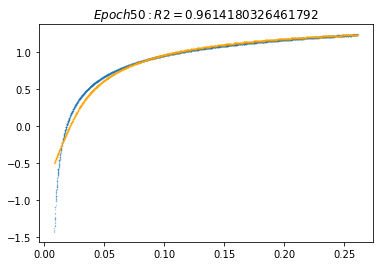

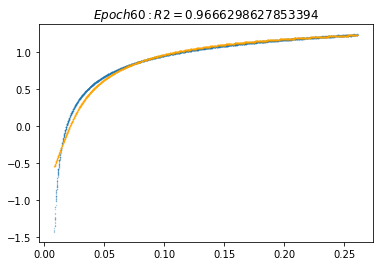

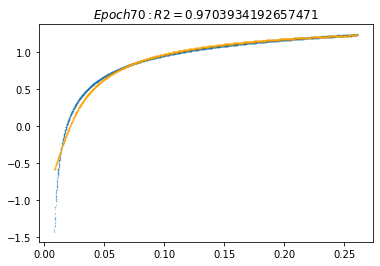

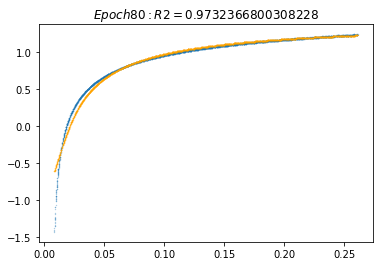

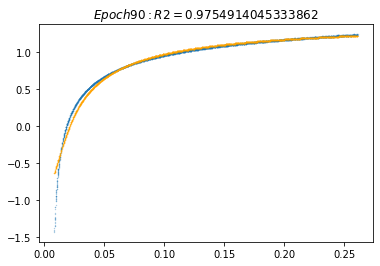

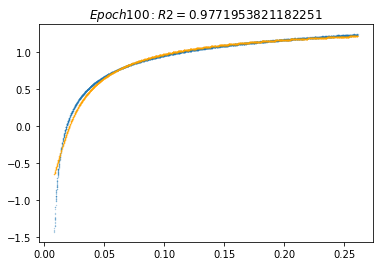

KeyboardInterrupt: 

In [24]:
# 训练网络

loader = data.DataLoader(dataset=data.TensorDataset(X, Y), batch_size=10, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.ASGD(CN.parameters())

CN.train()
for epoch in range(10000):
    for batch_x, batch_y in loader:
        y_pred = CN(batch_x)
        loss = loss_fn(y_pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    period = 10
    if (epoch + 1) % period == 0:
        plt.figure(num=int((epoch + 1)/period))
        Y_pred = CN(X)
        plt.scatter(X, Y, s=0.1, alpha=0.5)
        plt.scatter(X.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        plt.title(f'$Epoch {epoch + 1}: R2={r2_score(Y_pred, Y)}$')
        plt.show()

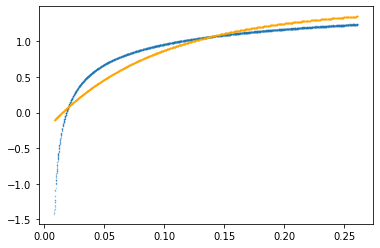

In [25]:
# 使用层数更深的核函数网络

CN = ConvexNet(X, Y, kernel_num=(100, 100))
Y_pred = CN(X)
plt.scatter(X, Y, s=0.1, alpha=0.5)
plt.scatter(X.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)

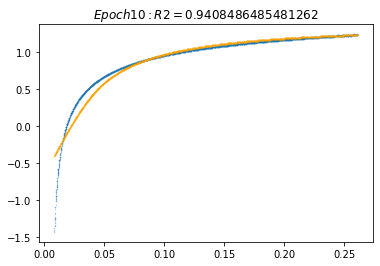

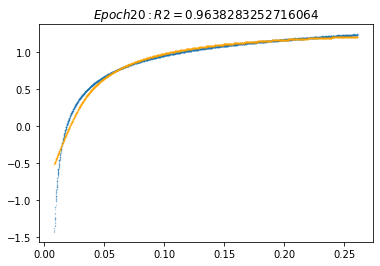

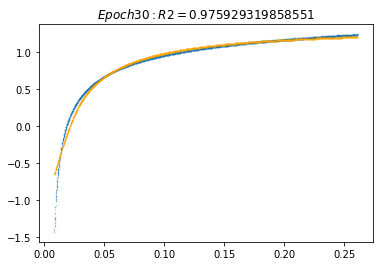

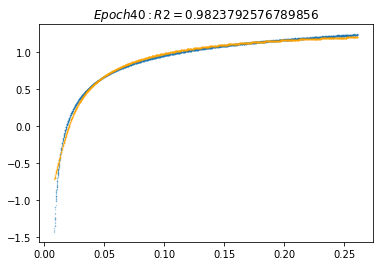

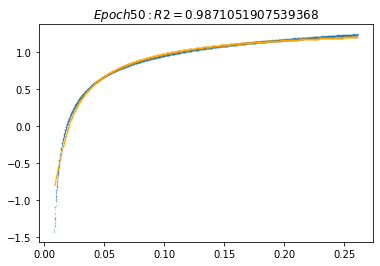

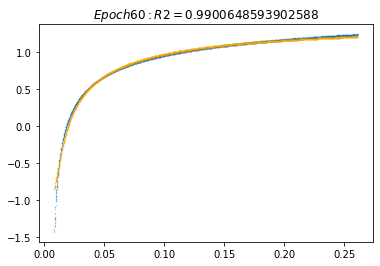

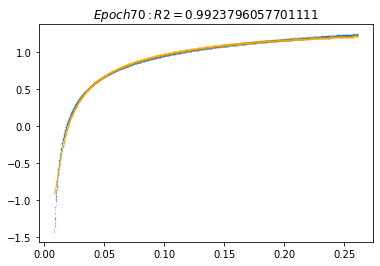

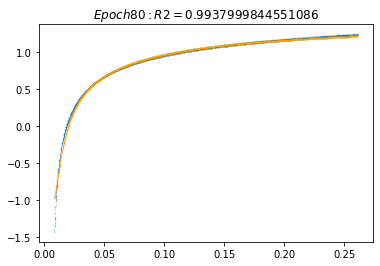

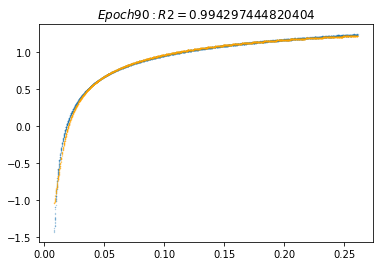

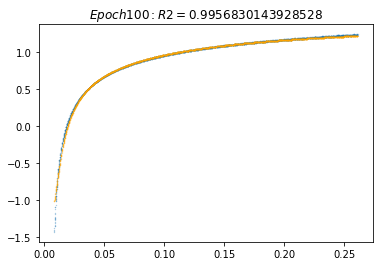

KeyboardInterrupt: 

In [26]:
# 训练网络

loader = data.DataLoader(dataset=data.TensorDataset(X, Y), batch_size=10, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.ASGD(CN.parameters())

CN.train()
for epoch in range(10000):
    for batch_x, batch_y in loader:
        y_pred = CN(batch_x)
        loss = loss_fn(y_pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    period = 10
    if (epoch + 1) % period == 0:
        plt.figure(num=int((epoch + 1)/period))
        Y_pred = CN(X)
        plt.scatter(X, Y, s=0.1, alpha=0.5)
        plt.scatter(X.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        plt.title(f'$Epoch {epoch + 1}: R2={r2_score(Y_pred, Y)}$')
        plt.show()

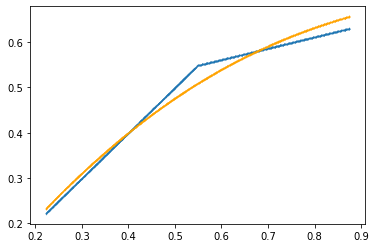

In [37]:
# 模拟分段函数数据并使用网络拟合

sample_size = 5000
X = torch.rand(1)*(torch.rand(sample_size, 1) + torch.rand(1))
Y = torch.empty_like(X)
Y[X < (X.max() + X.min())/2] = X[X < (X.max() + X.min())/2]
Y[X > (X.max() + X.min())/2] = X[X > (X.max() + X.min())/2]/4 + 3*(X.max() + X.min())/8
CN = ConvexNet(X, Y, kernel_num=100)
Y_pred = CN(X)
plt.scatter(X, Y, s=0.1, alpha=0.5)
plt.scatter(X.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)

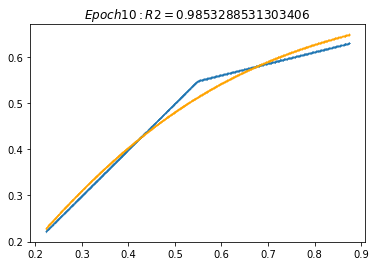

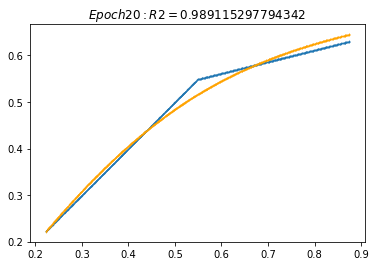

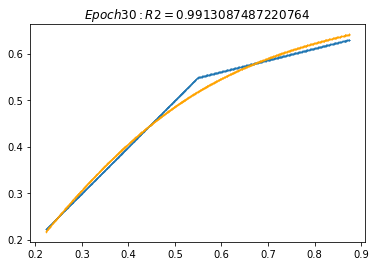

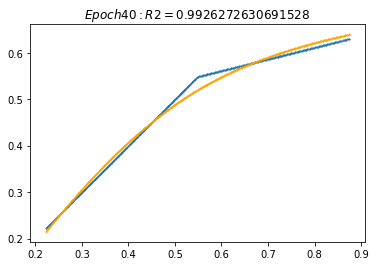

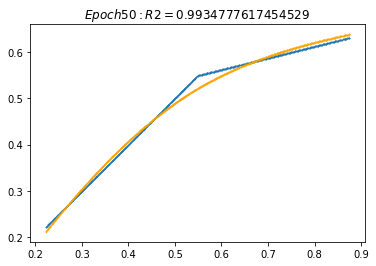

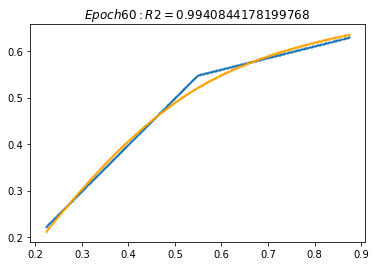

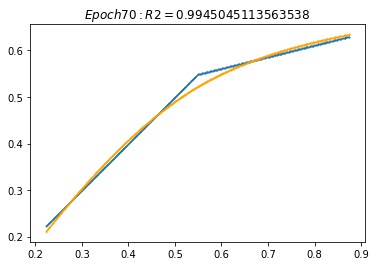

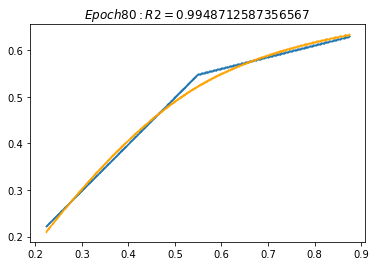

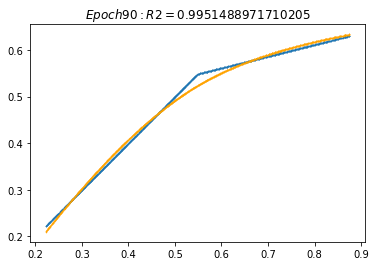

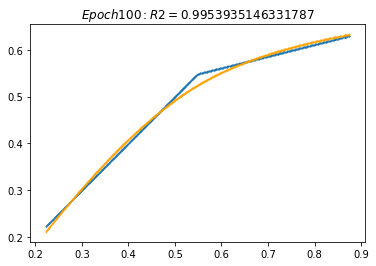

KeyboardInterrupt: 

In [38]:
# 训练网络

loader = data.DataLoader(dataset=data.TensorDataset(X, Y), batch_size=10, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.ASGD(CN.parameters())

CN.train()
for epoch in range(10000):
    for batch_x, batch_y in loader:
        y_pred = CN(batch_x)
        loss = loss_fn(y_pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    period = 10
    if (epoch + 1) % period == 0:
        plt.figure(num=int((epoch + 1)/period))
        Y_pred = CN(X)
        plt.scatter(X, Y, s=0.1, alpha=0.5)
        plt.scatter(X.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        plt.title(f'$Epoch {epoch + 1}: R2={r2_score(Y_pred, Y)}$')
        plt.show()

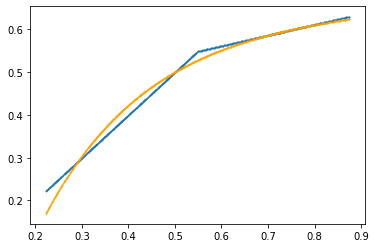

In [39]:
# 使用层数更深的网络拟合分段函数

CN = ConvexNet(X, Y, kernel_num=(100, 100))
Y_pred = CN(X)
plt.scatter(X, Y, s=0.1, alpha=0.5)
plt.scatter(X.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)

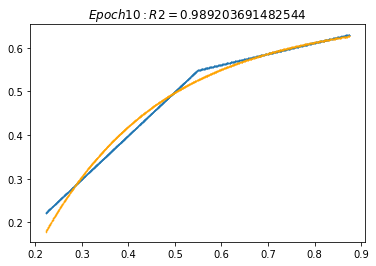

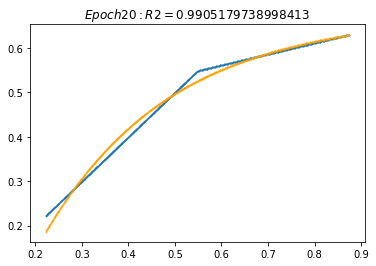

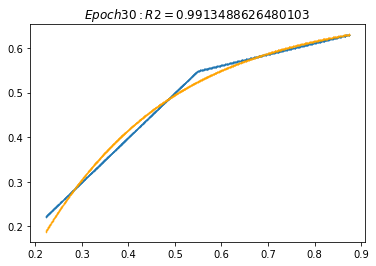

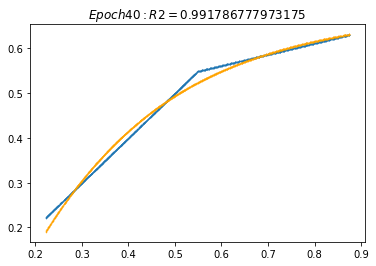

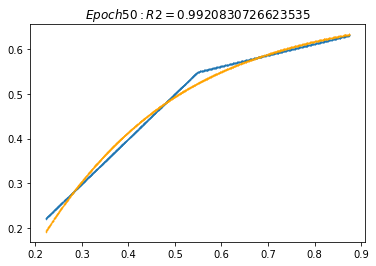

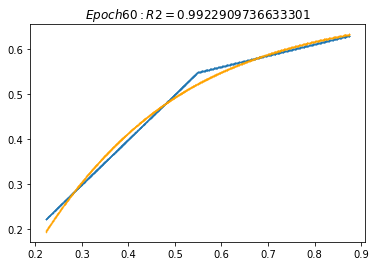

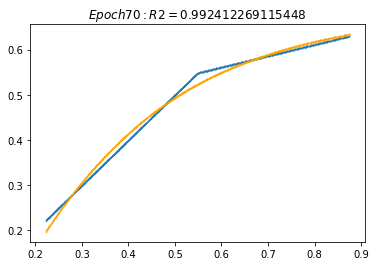

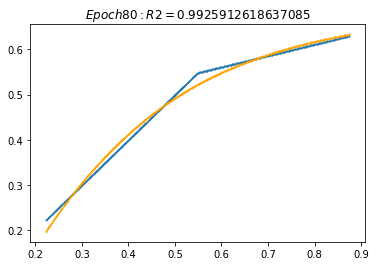

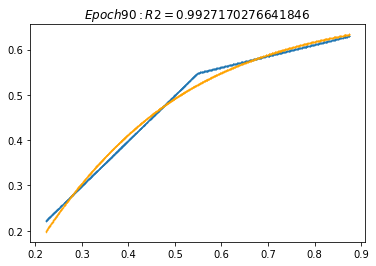

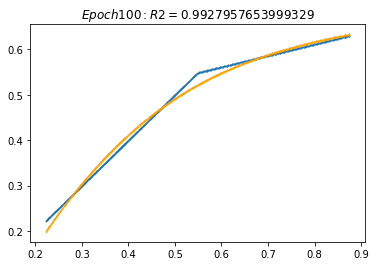

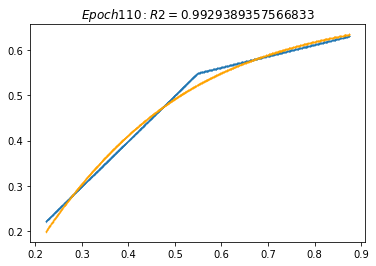

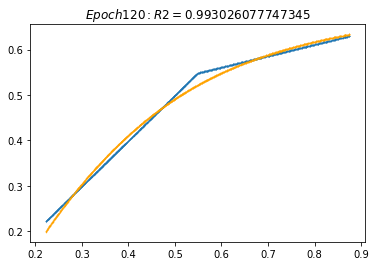

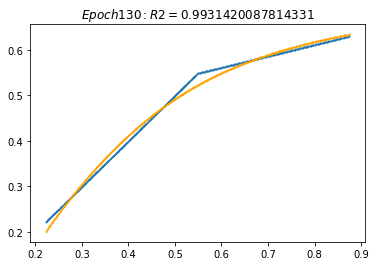

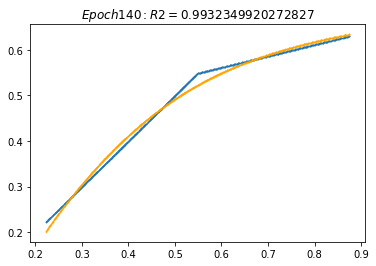

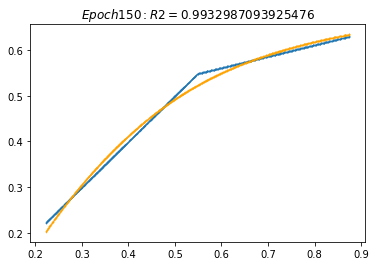

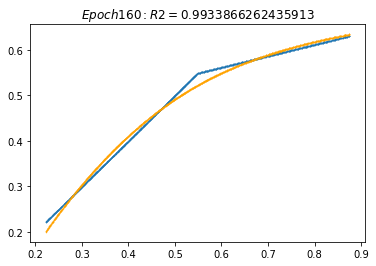

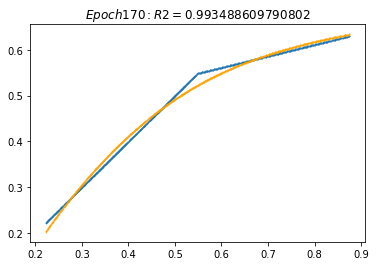

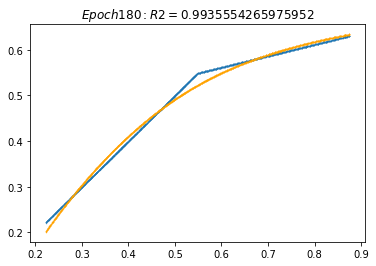

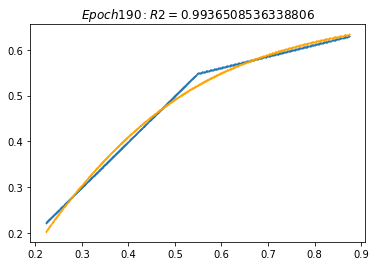

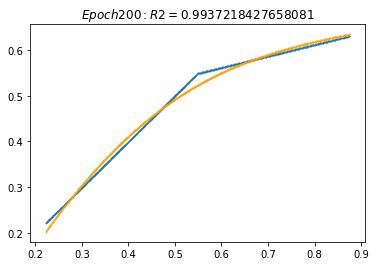

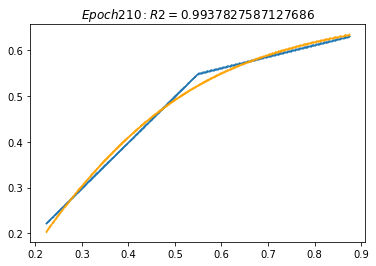

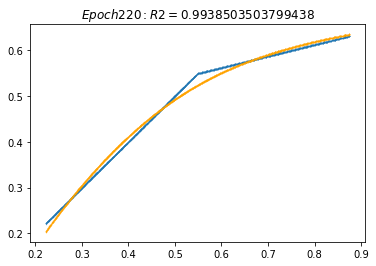

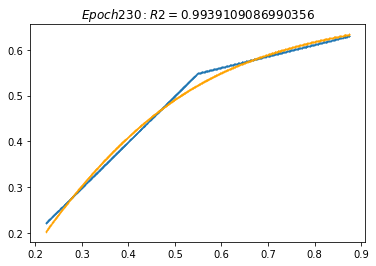

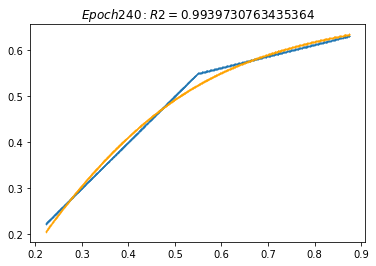

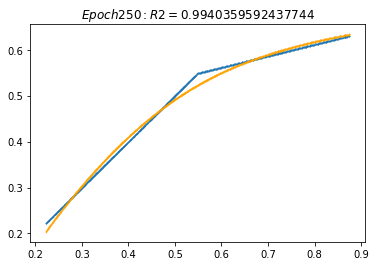

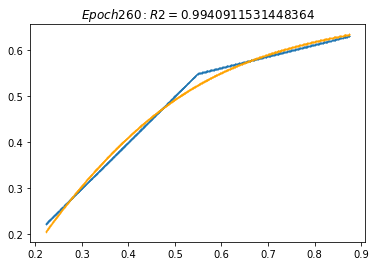

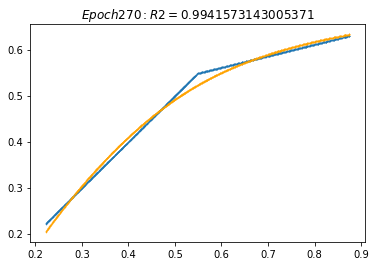

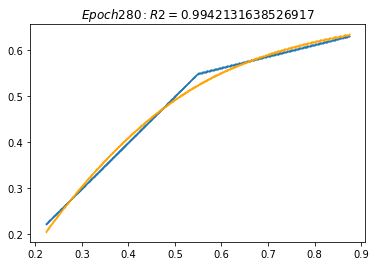

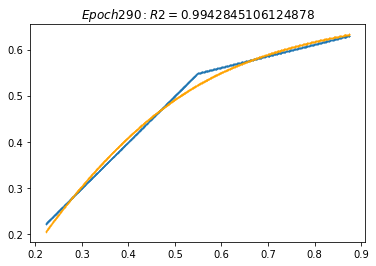

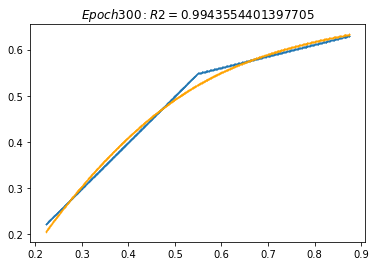

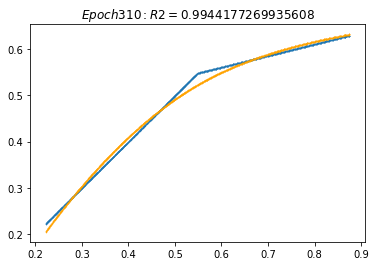

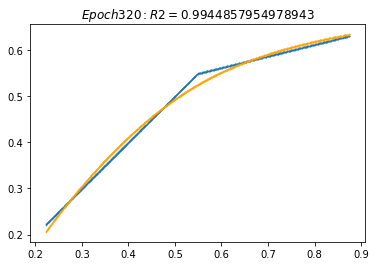

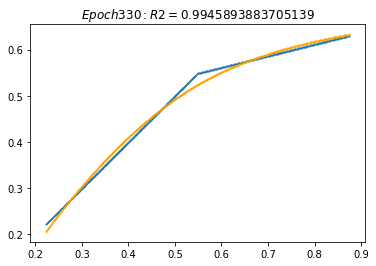

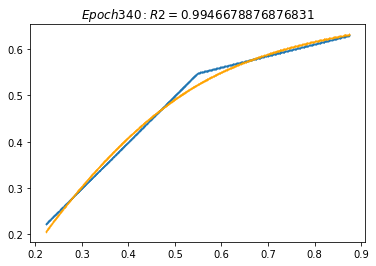

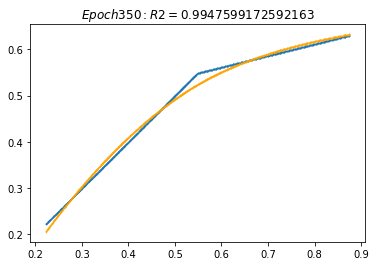

KeyboardInterrupt: 

In [40]:
# 训练网络

loader = data.DataLoader(dataset=data.TensorDataset(X, Y), batch_size=10, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.ASGD(CN.parameters())

CN.train()
for epoch in range(10000):
    for batch_x, batch_y in loader:
        y_pred = CN(batch_x)
        loss = loss_fn(y_pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    period = 10
    if (epoch + 1) % period == 0:
        plt.figure(num=int((epoch + 1)/period))
        Y_pred = CN(X)
        plt.scatter(X, Y, s=0.1, alpha=0.5)
        plt.scatter(X.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        plt.title(f'$Epoch {epoch + 1}: R2={r2_score(Y_pred, Y)}$')
        plt.show()